In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imsave
from skimage.color import rgb2gray
from fibmeasure.core.vtransforms import VRichardsonLucyDeconv, VBinarize, VOpening, VCCSFilter, VSkeletonizeEDT, VLineFittingTLS

In [2]:
image = imread('./assets/sample_1.bmp')
image = rgb2gray(image).astype(np.float32)

data = {"image": image}

In [3]:
transforms = [
    VRichardsonLucyDeconv(), VBinarize(), VOpening(), VCCSFilter(), VSkeletonizeEDT(), VLineFittingTLS()
]

In [4]:
views = []


result = data

for transform in transforms:
    result = transform(result)

    views.append(result[transform.visualization_key])

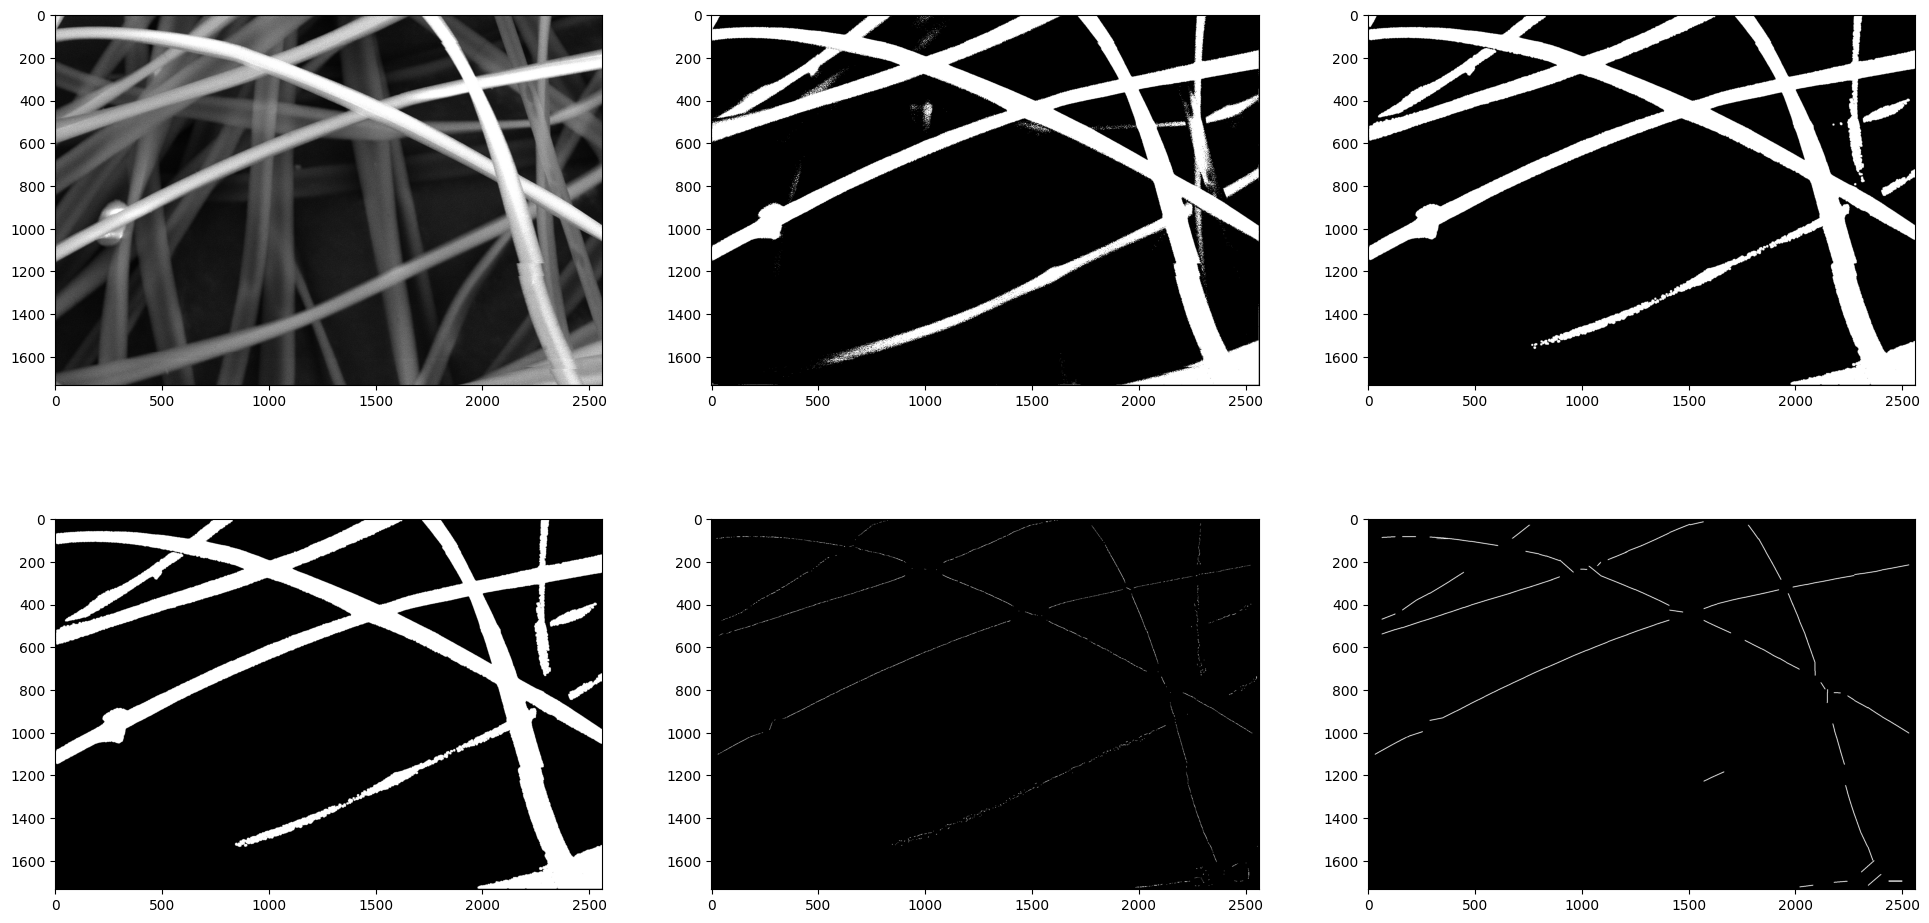

In [5]:
fig, axes = plt.subplots(2, len(views) // 2, figsize=(8 * len(views) // 2, 12))

for ax, image_like in zip(axes.reshape(-1), views):
    ax.imshow(image_like, cmap='gray')